In [1]:
# import các hàm cần thiết

import spectral.io.envi as envi		# hàm để đọc file .hdr và file .img
import numpy as np 					# để thao tác với ma trận
from spectral import open_image, imshow 	# để hiển thị hình ảnh
import pandas as pd                         # để đọc file excel
from typing import LiteralString
from sklearn.metrics import mean_squared_error #để tính Mean squared error
from sklearn import tree
import os
from sklearn.ensemble import RandomForestRegressor
from typing import Literal
import torch.nn as nn
import torch
import warnings
warnings.filterwarnings("ignore")


In [2]:
BAND_START_IX = 4
BAND_END_IX = 101
BAND_START_NAME = f"band_{BAND_START_IX}"
BAND_END_NAME = f"band_{BAND_END_IX}"
TOTAL_BAND = BAND_END_IX - BAND_START_IX + 1

In [3]:
BAND_START_NAME

'band_4'

In [4]:
BAND_END_NAME

'band_101'

In [5]:
TOTAL_BAND

98

In [6]:
# mở file .hdr và file .img
img = envi.open("hyper_20220913_3cm.hdr", "hyper_20220913_3cm.img")

In [7]:
# xem các thông tin cơ bản của file
img

	Data Source:   '.\hyper_20220913_3cm.img'
	# Rows:           6478
	# Samples:        5287
	# Bands:           122
	Interleave:        BSQ
	Quantization:   8 bits
	Data format:     uint8

In [10]:
# xem kích cỡ của ma trận
img.shape

(6478, 5287, 122)

In [9]:
def get_bands(row_num, col_num):
    return img[row_num, col_num]

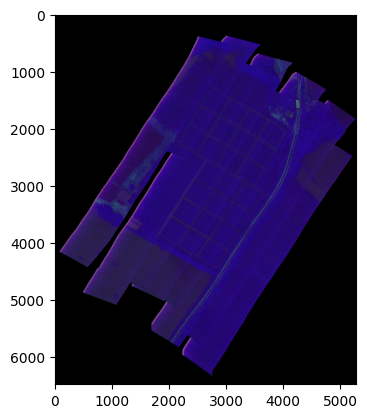

In [11]:
# hiển thị hình ảnh chụp được
view = imshow(img)

In [ ]:
# hàm này trả về các pixel nằm trong hình vuông có tọa độ (row_num, col_num) là tâm
# và độ dài cạnh là (2 * scopes + 1)
def pixel_in_scope(row_num, col_num, scopes):
    pixel_in_scope = set()

    for scope in range(1, scopes + 1):
        
        for i in range(row_num - scope, row_num + scope + 1):
            pixel_in_scope.add((i, col_num + scope))
            pixel_in_scope.add((i, col_num - scope))
            
        for i in range(col_num - scope, col_num + scope + 1):
            pixel_in_scope.add((row_num + scope, i))
            pixel_in_scope.add((row_num - scope, i))
            
    pixel_in_scope.add((row_num, col_num))
    return pixel_in_scope

In [ ]:
# lấy thông tin về map
with open("hyper_20220913_3cm.hdr", "r") as file:
    list_lines = file.read().split("\n")
    list_lines = filter(lambda line: "map info" in line, list_lines)
    map_infor = list(list_lines)[0]


In [ ]:
map_infor

'map info = {UTM, 1.000, 1.000, 530499.467, 2355871.685, 3.0000000000e-002, 3.0000000000e-002, 48, North, WGS-84, units=Meters}'

In [ ]:
# thông tin của map, tạm thời được đưa vào bằng tay
# "x1_pixel": tọa độ pixel x của điểm 1
# "y1_pixel": tọa độ pixel y của điểm 1
# "x1_axes": tọa độ trái đất x của điểm 1
# "y1_axes": tọa độ trái đất y của điểm 1
# "x_resolution": độ phân giải x của map
# "y_resolution": độ phân giải y của map
map_infor = {
    "col_1": 1.000,
    "row_1": 1.000,
    "east_1": 530499.467,
    "north_1": 2355871.685,
    "col_resolution": 3.0000000000e-002,
    "row_resolution": 3.0000000000e-002
}

In [ ]:
map_infor

{'col_1': 1.0,
 'row_1': 1.0,
 'east_1': 530499.467,
 'north_1': 2355871.685,
 'col_resolution': 0.03,
 'row_resolution': 0.03}

In [ ]:
# công thức lấy tọa độ trái đất khi biết tạo độ trái đất của điểm có tạo độ pixel (1, 1)
# (East - 530499.467 ) / 0.03 = số cột
# (2355871.685 - north) / 0.03 = cố hàng
# suy ra:
# East = 530499.467 + so cột * 0.03
# North = 2355871.685 - so hàng * 0.03 

In [ ]:
# từ tọa độ pixel, lấy tọa độ trái đất
def get_axes(row_num, col_num):
    east = map_infor["east_1"] + col_num * map_infor["col_resolution"]  
    north = map_infor["north_1"] - row_num * map_infor["row_resolution"]
    return (north, east)
    

In [ ]:
# từ tọa độ trái đất, lấy tọa độ pixel
def get_pixel(north, east):
    col_num = (east - map_infor["east_1"]) / map_infor["col_resolution"]
    row_num = (map_infor["north_1"] - north) / map_infor["row_resolution"]
    
    col_num = int(round(col_num, 0))
    row_num = int(round(row_num, 0))
    return (row_num, col_num)

In [ ]:
# đọc file excel chứa data của NPK và tọa độ Trái Đất
data_df = pd.read_excel("DATA_Mua2_PhuTho_2022_3.xlsx")

In [ ]:
data_df

,Treatment,Replicate,Sub-Replicate,East,North,Elevation,Chlorophyll,Rice_Height,Spectral_number,Digesion (g),...,Chlorophyll-a.1,Unnamed: 22,Wet weight (g),Dried weight (g),% Moiture,Digesion (g).1,P conc. (mg/kg).2,K conc. (mg/kg).2,N conc. (mg/kg).2,Chlorophyll-a.2
0,9/8/2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,23/9/2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,T1,1.0,530606.899,2355789.223,15.195,35.2,60.0,52,0.2497,...,35.8,T1.1,2355788.259,530607.202,15.180,0.2496,4408.453526,11414.262821,1366.862450,31.7
2,NaN,NaN,2.0,530602.233,2355788.619,15.198,38.1,58.0,53,0.2492,...,34.0,T1.2,2355787.076,530602.173,15.187,0.2497,4888.165799,13192.831398,1696.964518,33.6
3,NaN,NaN,3.0,530597.380,2355787.695,15.211,30.7,64.0,54,0.2509,...,34.9,T1.3,2355786.113,530597.674,15.209,0.2494,4457.999198,14094.827586,1328.177670,32.4
4,NaN,T2,1.0,530592.844,2355790.036,15.194,31.3,63.0,55,0.2500,...,29.8,T2.1,2355789.548,530594.048,15.217,0.2495,4356.713427,13018.036072,4760.907380,30.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,NaN,BC2,NaN,530553.290,2355759.834,15.213,35.4,70.0,107,0.2502,...,33.2,BC2,2355760.894,530555.404,15.207,0.2495,5666.833667,15003.006012,NaN,32.4
75,NaN,BC3,NaN,530592.596,2355733.669,15.178,42.1,70.0,108,0.2500,...,40.0,BC3,2355732.521,530591.790,15.185,0.2500,5459.300000,10918.000000,NaN,41.4
76,NaN,BC4,NaN,530622.914,2355777.478,15.030,43.9,68.0,109-110,0.2500,...,41.8,BC4,2355776.865,530622.044,15.024,0.2504,6248.901757,13170.926518,NaN,35.9
77,NaN,BC5,NaN,530618.803,2355796.165,15.220,41.4,75.0,111,0.2500,...,35.0,BC5,2355798.179,530620.573,15.186,0.2503,6137.135437,12318.218138,NaN,29.6


In [ ]:
data_df.columns

Index(['Treatment', 'Replicate', 'Sub-Replicate', 'East', 'North', 'Elevation',
       'Chlorophyll', 'Rice_Height', 'Spectral_number', 'Digesion (g)',
       'P conc. (mg/kg)', 'K conc. (mg/kg)', 'N conc. (mg/kg)',
       'Chlorophyll-a', 'Unnamed: 14', 'East.1', 'North.1', 'Elevation.1',
       'P conc. (mg/kg).1', 'K conc. (mg/kg).1', 'N conc. (mg/kg).1',
       'Chlorophyll-a.1', 'Unnamed: 22', 'Wet weight (g)', 'Dried weight (g)',
       '% Moiture', 'Digesion (g).1', 'P conc. (mg/kg).2', 'K conc. (mg/kg).2',
       'N conc. (mg/kg).2', 'Chlorophyll-a.2'],
      dtype='object')

In [ ]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Treatment          1 non-null      object 
 1   Replicate          30 non-null     object 
 2   Sub-Replicate      72 non-null     float64
 3   East               78 non-null     float64
 4   North              78 non-null     float64
 5   Elevation          78 non-null     float64
 6   Chlorophyll        77 non-null     float64
 7   Rice_Height        77 non-null     float64
 8   Spectral_number    77 non-null     object 
 9   Digesion (g)       77 non-null     float64
 10  P conc. (mg/kg)    77 non-null     float64
 11  K conc. (mg/kg)    77 non-null     float64
 12  N conc. (mg/kg)    77 non-null     float64
 13  Chlorophyll-a      77 non-null     float64
 14  Unnamed: 14        77 non-null     object 
 15  East.1             76 non-null     float64
 16  North.1            76 non-nu

In [ ]:
# Lấy cột dữ liệu đo được của ngày 13/9/2022
data_df_13_09_2022 = data_df.loc[1:, "Unnamed: 14":"Chlorophyll-a.1"]

In [ ]:
data_df_13_09_2022.rename(columns={
    "Unnamed: 14": "type_of_field"
}, inplace=True)

In [ ]:
# Bỏ đi những dòng bị thiếu tên điểm 
data_df_13_09_2022 = data_df_13_09_2022[~pd.isna(data_df_13_09_2022["type_of_field"])]

In [ ]:
data_df_13_09_2022

,type_of_field,East.1,North.1,Elevation.1,P conc. (mg/kg).1,K conc. (mg/kg).1,N conc. (mg/kg).1,Chlorophyll-a.1
1,T1.1,530605.915,2355788.377,15.193,6098.182181,12505.992809,4311.970060,35.8
2,T1.2,530601.735,2355788.448,15.178,5037.174349,12338.677355,4787.270920,34.0
3,T1.3,530597.008,2355787.118,15.206,6471.319695,14923.786602,5286.813480,34.9
4,T2.1,530593.342,2355789.827,15.215,6433.340016,17184.242181,3066.571650,29.8
5,T2.2,530591.652,2355794.783,15.236,5679.671869,13274.309724,3433.145680,36.1
...,...,...,...,...,...,...,...,...
72,J12.3,530582.155,2355781.790,15.238,7009.292566,16528.776978,7556.516150,38.6
74,BC2,530553.718,2355758.342,15.224,5885.628743,14264.471058,2265.424250,33.2
75,BC3,530591.520,2355732.444,15.206,7505.289421,16167.664671,3268.614069,40.0
76,BC4,530622.015,2355776.121,15.086,6279.883674,10340.954673,2980.889693,41.8


In [ ]:
data_df_13_09_2022.info()

<class 'pandas.core.frame.DataFrame'>
Index: 76 entries, 1 to 77
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type_of_field      76 non-null     object 
 1   East.1             76 non-null     float64
 2   North.1            76 non-null     float64
 3   Elevation.1        76 non-null     float64
 4   P conc. (mg/kg).1  76 non-null     float64
 5   K conc. (mg/kg).1  76 non-null     float64
 6   N conc. (mg/kg).1  76 non-null     float64
 7   Chlorophyll-a.1    76 non-null     float64
dtypes: float64(7), object(1)
memory usage: 5.3+ KB


In [ ]:
# Tạo thêm cột 2 tọa độ pixel
data_df_13_09_2022["row_num"] = [None] * len(data_df_13_09_2022)
data_df_13_09_2022["col_num"] = [None] * len(data_df_13_09_2022)

In [ ]:
data_df_13_09_2022

,type_of_field,East.1,North.1,Elevation.1,P conc. (mg/kg).1,K conc. (mg/kg).1,N conc. (mg/kg).1,Chlorophyll-a.1,row_num,col_num
1,T1.1,530605.915,2355788.377,15.193,6098.182181,12505.992809,4311.970060,35.8,None,None
2,T1.2,530601.735,2355788.448,15.178,5037.174349,12338.677355,4787.270920,34.0,None,None
3,T1.3,530597.008,2355787.118,15.206,6471.319695,14923.786602,5286.813480,34.9,None,None
4,T2.1,530593.342,2355789.827,15.215,6433.340016,17184.242181,3066.571650,29.8,None,None
5,T2.2,530591.652,2355794.783,15.236,5679.671869,13274.309724,3433.145680,36.1,None,None
...,...,...,...,...,...,...,...,...,...,...
72,J12.3,530582.155,2355781.790,15.238,7009.292566,16528.776978,7556.516150,38.6,None,None
74,BC2,530553.718,2355758.342,15.224,5885.628743,14264.471058,2265.424250,33.2,None,None
75,BC3,530591.520,2355732.444,15.206,7505.289421,16167.664671,3268.614069,40.0,None,None
76,BC4,530622.015,2355776.121,15.086,6279.883674,10340.954673,2980.889693,41.8,None,None


In [ ]:
data_df_13_09_2022.columns

Index(['type_of_field', 'East.1', 'North.1', 'Elevation.1',
       'P conc. (mg/kg).1', 'K conc. (mg/kg).1', 'N conc. (mg/kg).1',
       'Chlorophyll-a.1', 'row_num', 'col_num'],
      dtype='object')

In [ ]:
# Định nghĩa hàm tính tọa độ pixel của điểm thực đo ngoài thực nghiệm
def fill_row_num_and_col_num(index, row, df: pd.DataFrame):
    east = row["East.1"]
    north = row["North.1"]
    row_num, col_num = get_pixel(north, east)
    df.at[index, "row_num"] = row_num
    df.at[index, "col_num"] = col_num

In [ ]:
# Lặp hàm tính tọa độ pixel trên cho từng dòng
for index, row in data_df_13_09_2022.iterrows():
    fill_row_num_and_col_num(index, row, data_df_13_09_2022)

In [ ]:
data_df_13_09_2022

,type_of_field,East.1,North.1,Elevation.1,P conc. (mg/kg).1,K conc. (mg/kg).1,N conc. (mg/kg).1,Chlorophyll-a.1,row_num,col_num
1,T1.1,530605.915,2355788.377,15.193,6098.182181,12505.992809,4311.970060,35.8,2777,3548
2,T1.2,530601.735,2355788.448,15.178,5037.174349,12338.677355,4787.270920,34.0,2775,3409
3,T1.3,530597.008,2355787.118,15.206,6471.319695,14923.786602,5286.813480,34.9,2819,3251
4,T2.1,530593.342,2355789.827,15.215,6433.340016,17184.242181,3066.571650,29.8,2729,3129
5,T2.2,530591.652,2355794.783,15.236,5679.671869,13274.309724,3433.145680,36.1,2563,3073
...,...,...,...,...,...,...,...,...,...,...
72,J12.3,530582.155,2355781.790,15.238,7009.292566,16528.776978,7556.516150,38.6,2997,2756
74,BC2,530553.718,2355758.342,15.224,5885.628743,14264.471058,2265.424250,33.2,3778,1808
75,BC3,530591.520,2355732.444,15.206,7505.289421,16167.664671,3268.614069,40.0,4641,3068
76,BC4,530622.015,2355776.121,15.086,6279.883674,10340.954673,2980.889693,41.8,3185,4085


In [ ]:
data_df_13_09_2022.info()

<class 'pandas.core.frame.DataFrame'>
Index: 76 entries, 1 to 77
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type_of_field      76 non-null     object 
 1   East.1             76 non-null     float64
 2   North.1            76 non-null     float64
 3   Elevation.1        76 non-null     float64
 4   P conc. (mg/kg).1  76 non-null     float64
 5   K conc. (mg/kg).1  76 non-null     float64
 6   N conc. (mg/kg).1  76 non-null     float64
 7   Chlorophyll-a.1    76 non-null     float64
 8   row_num            76 non-null     object 
 9   col_num            76 non-null     object 
dtypes: float64(7), object(3)
memory usage: 8.6+ KB


In [ ]:
# Lấy giá trị max của từng band trong các ô xung quanh
def get_max_bands(row_num, col_num, scope):
    number_points = 2 * scope + 1
    band_in_scope = np.zeros((number_points ** 2, 122))
    for i, (row_num, col_num) in enumerate(pixel_in_scope(row_num, col_num, scope)):
        band_in_scope[i] = img[row_num, col_num, :].reshape(122)
    return np.max(band_in_scope, axis=0) # Lấy giá trị max của từng cột (band)

In [ ]:
def generate_sample(df: pd.DataFrame, type_of_output: Literal["N", "P", "K"] = None, type_of_field: Literal["T", "J", "BC"] = None):
    if type_of_output == "N":
        output_column = "N conc. (mg/kg).1"
    elif type_of_output == "K":
        output_column = "K conc. (mg/kg).1"
    elif type_of_output == "P":
        output_column = "P conc. (mg/kg).1"
    
    sample = df[["type_of_field",output_column, "row_num", "col_num"]]

    #Tạo bảng gồm giá trị của N, tọa độ pixel điểm thực nghiệm và 122 giá trị trống
    for i in range(BAND_START_IX, BAND_END_IX + 1):
        sample[f"band_{i}"] = [None] * len(sample)

    # Thêm 122 giá trị max của 122 band vào tập data sample N
    for index, row in sample.iterrows():
        row_num = row["row_num"]
        col_num = row["col_num"]
        sample.loc[index, BAND_START_NAME:BAND_END_NAME] = get_max_bands(row_num, col_num, 3)[BAND_START_IX:BAND_END_IX + 1]
    
    if type_of_field:
        if type(type_of_field) == list:
            total_condition = sample["type_of_field"].str.startswith(type_of_field[0])
            for field in type_of_field[1:]:
                condition = sample["type_of_field"].str.startswith(field)
                total_condition |= condition
            sample = sample[total_condition]
        else:
            sample = sample[sample["type_of_field"].str.startswith(type_of_field)] 
    sample.rename(columns={
        output_column: "target"
    }, inplace=True)
    return sample
    

In [ ]:
generate_sample(data_df_13_09_2022, "N", "T")

,type_of_field,target,row_num,col_num,band_4,band_5,band_6,band_7,band_8,band_9,...,band_92,band_93,band_94,band_95,band_96,band_97,band_98,band_99,band_100,band_101
1,T1.1,4311.970060,2777,3548,14.0,14.0,11.0,10.0,8.0,8.0,...,90.0,88.0,90.0,87.0,91.0,88.0,89.0,87.0,86.0,87.0
2,T1.2,4787.270920,2775,3409,43.0,18.0,10.0,9.0,12.0,12.0,...,111.0,115.0,108.0,107.0,103.0,108.0,107.0,101.0,104.0,100.0
3,T1.3,5286.813480,2819,3251,20.0,15.0,12.0,9.0,10.0,9.0,...,95.0,84.0,83.0,88.0,86.0,90.0,89.0,83.0,84.0,84.0
4,T2.1,3066.571650,2729,3129,18.0,14.0,9.0,10.0,8.0,8.0,...,86.0,82.0,78.0,83.0,78.0,87.0,76.0,79.0,79.0,81.0
5,T2.2,3433.145680,2563,3073,16.0,12.0,13.0,10.0,8.0,9.0,...,98.0,94.0,93.0,88.0,91.0,89.0,91.0,95.0,95.0,93.0
6,T2.3,2551.822300,2416,3050,14.0,15.0,11.0,10.0,27.0,8.0,...,94.0,91.0,87.0,92.0,87.0,82.0,85.0,83.0,82.0,82.0
7,T3.1,6948.808340,2347,2897,47.0,19.0,9.0,10.0,8.0,11.0,...,82.0,78.0,83.0,77.0,72.0,74.0,75.0,75.0,77.0,75.0
8,T3.2,6590.181000,2342,2737,15.0,11.0,12.0,12.0,13.0,10.0,...,131.0,126.0,131.0,122.0,125.0,124.0,128.0,128.0,122.0,133.0
9,T3.3,7119.512810,2429,2604,17.0,15.0,12.0,43.0,9.0,11.0,...,96.0,87.0,87.0,89.0,85.0,83.0,84.0,85.0,84.0,85.0
10,T4.1,5642.719150,2310,2456,18.0,19.0,12.0,9.0,11.0,8.0,...,111.0,109.0,107.0,109.0,103.0,105.0,101.0,104.0,103.0,104.0


In [ ]:
# dùng deep learning

In [ ]:
def create_X_train_Y_train(df: pd.DataFrame):
    X = df.loc[:, BAND_START_NAME:BAND_END_NAME].to_numpy()
    Y = df.loc[:, "target"].to_numpy()

    X = X.astype(np.float32)
    Y = Y.astype(np.float32)

    total_sample = len(X)
    max_train = int(total_sample * 1)
    # max_val = int(total_sample * 1)

    X_train = torch.tensor(X[0:max_train])
    # X_val = torch.tensor(X[max_train:max_val])
    # X_test = torch.tensor(X[max_val:])

    Y_train = torch.tensor(Y[0:max_train])
    # Y_val = torch.tensor(Y[max_train:max_val])
    # Y_test = torch.tensor(Y[max_val:])

    Y_train = Y_train.reshape((Y_train.shape[0], 1))
    # Y_val = Y_val.reshape((Y_val.shape[0], 1))
    # Y_test = Y_test.reshape((Y_test.shape[0], 1))

    return X_train, Y_train

In [ ]:
class NeutralNetwork(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(TOTAL_BAND, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 1)
        )
    
    def forward(self, x):
        N_value = self.linear_relu_stack(x)
        return N_value

In [ ]:
def train_model(model, loss_fn, optimizer, X_train, Y_train, X_val, Y_val, n_epochs, min_loss=0.5):
    for epoch in range(n_epochs):
        model.train()

        y_pred = model(X_train)
        loss = loss_fn(y_pred, Y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            model.eval()
            with torch.inference_mode():
                loss = np.sqrt(loss)
                # y_pred_val = model(X_val)
                # loss_val = np.sqrt(loss_fn(y_pred_val, Y_val))
                # print(f"Epoch: {epoch} | loss train: {loss} | loss val: {loss_val}")
                print(f"Epoch: {epoch} | loss train: {loss}")
                if loss < min_loss:
                    return

In [ ]:
RERUN_NN_MODEL = "N"

In [ ]:
def predict_using_neutral_network(X_train, Y_train, X_target, Y_target, name_file_output, super_param={"lr": 0.0001, "weight_decay": 1e-5, "n_epochs": 40000, "stop_value": 0.5}, re_run="N"):
    loss_fn = nn.MSELoss()
    if not os.path.exists(name_file_output) or re_run == "Y" or RERUN_NN_MODEL:
        model = NeutralNetwork()
        optimizer = torch.optim.Adam(model.parameters(), lr=super_param["lr"], weight_decay=super_param["weight_decay"])
        n_epochs = 40000
        train_model(model, loss_fn, optimizer, X_train, Y_train, [], [], n_epochs, 0.5)
        torch.jit.script(model).save(name_file_output)
    else:
        model = torch.jit.load(name_file_output)
    
    model.eval()
    with torch.inference_mode():
        loss_fn = nn.MSELoss()
        Y_target_pred = model(X_target)
        loss = loss_fn(Y_target, Y_target_pred)
        return np.sqrt(loss), Y_target_pred

In [ ]:
def predict_using_random_forest(X_train, Y_train, X_target, Y_target, super_param={}):
    clf = RandomForestRegressor()
    Y_train = Y_train.reshape(Y_train.shape[0])
    clf = clf.fit(X_train, Y_train)
    Y_pred = clf.predict(X_target)
    loss = np.sqrt(mean_squared_error(Y_target, Y_pred))
    return loss, Y_pred
    

In [ ]:
def predict_using_decision_tree(X_train, Y_train, X_target, Y_target, super_param={}):
    clf = tree.DecisionTreeRegressor()
    Y_train = Y_train.reshape(Y_train.shape[0])
    clf = clf.fit(X_train, Y_train)
    Y_pred = clf.predict(X_target)
    loss = np.sqrt(mean_squared_error(Y_target, Y_pred))
    return loss, Y_pred
    

In [ ]:
#Dự đoán Nito

In [ ]:
target_value = "N"
train_field = "T"
sample = generate_sample(data_df_13_09_2022, target_value, train_field)
X_train, Y_train = create_X_train_Y_train(sample)
sample_target = generate_sample(data_df_13_09_2022, target_value, "BC")
X_target, Y_target = create_X_train_Y_train(sample_target)
super_param={"lr": 0.001, "weight_decay": 1e-5, "n_epochs": 40000, "stop_value": 0.5}
re_run = "N"
loss_NN, pred_NN = predict_using_neutral_network(X_train, Y_train, X_target, Y_target, f"{'_'.join(list(train_field))}_model_predict_{target_value}_2.pt", super_param, re_run)
print(f"{loss_NN=}")
print(f"{pred_NN=}")
loss_RF, pred_RF = predict_using_random_forest(X_train, Y_train, X_target, Y_target, super_param)
print(f"{loss_RF=}")
print(f"{pred_RF=}")
loss_DT, pred_DT = predict_using_decision_tree(X_train, Y_train, X_target, Y_target, super_param)
print(f"{loss_DT=}")
print(f"{pred_DT=}")

Epoch: 0 | loss train: 5287.9921875
Epoch: 100 | loss train: 1961.630859375
Epoch: 200 | loss train: 1750.2176513671875
Epoch: 300 | loss train: 1117.271484375
Epoch: 400 | loss train: 801.7138061523438
Epoch: 500 | loss train: 569.9813842773438
Epoch: 600 | loss train: 432.4056396484375
Epoch: 700 | loss train: 564.3724365234375
Epoch: 800 | loss train: 358.99688720703125
Epoch: 900 | loss train: 267.75439453125
Epoch: 1000 | loss train: 251.62118530273438
Epoch: 1100 | loss train: 273.3931579589844
Epoch: 1200 | loss train: 164.75439453125
Epoch: 1300 | loss train: 244.81680297851562
Epoch: 1400 | loss train: 197.86843872070312
Epoch: 1500 | loss train: 157.14755249023438
Epoch: 1600 | loss train: 190.35531616210938
Epoch: 1700 | loss train: 155.8056640625
Epoch: 1800 | loss train: 130.05213928222656
Epoch: 1900 | loss train: 91.7403793334961
Epoch: 2000 | loss train: 58.569068908691406
Epoch: 2100 | loss train: 65.68785095214844
Epoch: 2200 | loss train: 107.15345764160156
Epoch: 23

In [ ]:
target_value = "N"
train_field = "J"
sample = generate_sample(data_df_13_09_2022, target_value, train_field)
X_train, Y_train = create_X_train_Y_train(sample)
sample_target = generate_sample(data_df_13_09_2022, target_value, "BC")
X_target, Y_target = create_X_train_Y_train(sample_target)
super_param={"lr": 0.0001, "weight_decay": 1e-5, "n_epochs": 40000, "stop_value": 2}
re_run = "Y"
loss_NN, pred_NN = predict_using_neutral_network(X_train, Y_train, X_target, Y_target, f"{'_'.join(list(train_field))}_model_predict_{target_value}_2.pt", super_param, re_run)
print(f"{loss_NN=}")
print(f"{pred_NN=}")
loss_RF, pred_RF = predict_using_random_forest(X_train, Y_train, X_target, Y_target, super_param)
print(f"{loss_RF=}")
print(f"{pred_RF=}")
loss_DT, pred_DT = predict_using_decision_tree(X_train, Y_train, X_target, Y_target, super_param)
print(f"{loss_DT=}")
print(f"{pred_DT=}")

Epoch: 0 | loss train: 6206.9326171875
Epoch: 100 | loss train: 6036.2021484375
Epoch: 200 | loss train: 2243.7275390625
Epoch: 300 | loss train: 2237.00244140625
Epoch: 400 | loss train: 2231.451904296875
Epoch: 500 | loss train: 2221.82421875
Epoch: 600 | loss train: 2206.134521484375
Epoch: 700 | loss train: 2183.83642578125
Epoch: 800 | loss train: 2149.5556640625
Epoch: 900 | loss train: 2092.3408203125
Epoch: 1000 | loss train: 1987.93017578125
Epoch: 1100 | loss train: 1894.0159912109375
Epoch: 1200 | loss train: 1772.2864990234375
Epoch: 1300 | loss train: 1459.420166015625
Epoch: 1400 | loss train: 1046.856201171875
Epoch: 1500 | loss train: 912.9402465820312
Epoch: 1600 | loss train: 824.2400512695312
Epoch: 1700 | loss train: 753.7316284179688
Epoch: 1800 | loss train: 689.829345703125
Epoch: 1900 | loss train: 641.2338256835938
Epoch: 2000 | loss train: 594.118896484375
Epoch: 2100 | loss train: 561.5919799804688
Epoch: 2200 | loss train: 529.2410278320312
Epoch: 2300 | los

In [ ]:
target_value = "N"
train_field = ["T", "J"]
sample = generate_sample(data_df_13_09_2022, target_value, train_field)
X_train, Y_train = create_X_train_Y_train(sample)
sample_target = generate_sample(data_df_13_09_2022, target_value, "BC")
X_target, Y_target = create_X_train_Y_train(sample_target)
super_param={"lr": 0.0001, "weight_decay": 1e-5, "n_epochs": 40000, "stop_value": 0.5}
re_run = "N"
loss_NN, pred_NN = predict_using_neutral_network(X_train, Y_train, X_target, Y_target, f"{'_'.join(list(train_field))}_model_predict_{target_value}_2.pt", super_param, re_run)
print(f"{loss_NN=}")
print(f"{pred_NN=}")
loss_RF, pred_RF = predict_using_random_forest(X_train, Y_train, X_target, Y_target, super_param)
print(f"{loss_RF=}")
print(f"{pred_RF=}")
loss_DT, pred_DT = predict_using_decision_tree(X_train, Y_train, X_target, Y_target, super_param)
print(f"{loss_DT=}")
print(f"{pred_DT=}")

Epoch: 0 | loss train: 5765.8330078125
Epoch: 100 | loss train: 5615.654296875
Epoch: 200 | loss train: 2122.3330078125
Epoch: 300 | loss train: 2119.249755859375
Epoch: 400 | loss train: 2117.529296875
Epoch: 500 | loss train: 2114.072509765625
Epoch: 600 | loss train: 2108.59228515625
Epoch: 700 | loss train: 2099.8623046875
Epoch: 800 | loss train: 2084.124755859375
Epoch: 900 | loss train: 2049.208740234375
Epoch: 1000 | loss train: 1967.3607177734375
Epoch: 1100 | loss train: 1754.36572265625
Epoch: 1200 | loss train: 1500.2393798828125
Epoch: 1300 | loss train: 1340.5423583984375
Epoch: 1400 | loss train: 1250.7044677734375
Epoch: 1500 | loss train: 1190.007080078125
Epoch: 1600 | loss train: 1127.2379150390625
Epoch: 1700 | loss train: 1085.2645263671875
Epoch: 1800 | loss train: 1046.890869140625
Epoch: 1900 | loss train: 1011.197021484375
Epoch: 2000 | loss train: 976.3375854492188
Epoch: 2100 | loss train: 954.4782104492188
Epoch: 2200 | loss train: 922.3305053710938
Epoch: 2

In [ ]:
# Dự đoán Photpho

In [ ]:
target_value = "P"
train_field = "T"
sample = generate_sample(data_df_13_09_2022, target_value, train_field)
X_train, Y_train = create_X_train_Y_train(sample)
sample_target = generate_sample(data_df_13_09_2022, target_value, "BC")
X_target, Y_target = create_X_train_Y_train(sample_target)
super_param={"lr": 0.0001, "weight_decay": 1e-5, "n_epochs": 40000, "stop_value": 0.5}
re_run = "N"
loss_NN, pred_NN = predict_using_neutral_network(X_train, Y_train, X_target, Y_target, f"{'_'.join(list(train_field))}_model_predict_{target_value}_2.pt", super_param, re_run)
print(f"{loss_NN=}")
print(f"{pred_NN=}")
loss_RF, pred_RF = predict_using_random_forest(X_train, Y_train, X_target, Y_target, super_param)
print(f"{loss_RF=}")
print(f"{pred_RF=}")
loss_DT, pred_DT = predict_using_decision_tree(X_train, Y_train, X_target, Y_target, super_param)
print(f"{loss_DT=}")
print(f"{pred_DT=}")

Epoch: 0 | loss train: 5990.28173828125
Epoch: 100 | loss train: 5776.95263671875
Epoch: 200 | loss train: 790.884765625
Epoch: 300 | loss train: 780.4788818359375
Epoch: 400 | loss train: 772.1525268554688
Epoch: 500 | loss train: 756.95263671875
Epoch: 600 | loss train: 730.9122924804688
Epoch: 700 | loss train: 693.7506713867188
Epoch: 800 | loss train: 657.3466186523438
Epoch: 900 | loss train: 602.9769287109375
Epoch: 1000 | loss train: 502.7089538574219
Epoch: 1100 | loss train: 408.2283630371094
Epoch: 1200 | loss train: 342.7757873535156
Epoch: 1300 | loss train: 293.5379943847656
Epoch: 1400 | loss train: 257.544921875
Epoch: 1500 | loss train: 228.84620666503906
Epoch: 1600 | loss train: 206.94920349121094
Epoch: 1700 | loss train: 185.49302673339844
Epoch: 1800 | loss train: 170.70848083496094
Epoch: 1900 | loss train: 157.85256958007812
Epoch: 2000 | loss train: 143.68569946289062
Epoch: 2100 | loss train: 131.73370361328125
Epoch: 2200 | loss train: 121.45365142822266
Epoc

In [ ]:
target_value = "P"
train_field = "J"
sample = generate_sample(data_df_13_09_2022, target_value, train_field)
X_train, Y_train = create_X_train_Y_train(sample)
sample_target = generate_sample(data_df_13_09_2022, target_value, "BC")
X_target, Y_target = create_X_train_Y_train(sample_target)
super_param={"lr": 0.0001, "weight_decay": 1e-5, "n_epochs": 40000, "stop_value": 0.5}
re_run = "N"
loss_NN, pred_NN = predict_using_neutral_network(X_train, Y_train, X_target, Y_target, f"{'_'.join(list(train_field))}_model_predict_{target_value}_2.pt", super_param, re_run)
print(f"{loss_NN=}")
print(f"{pred_NN=}")
loss_RF, pred_RF = predict_using_random_forest(X_train, Y_train, X_target, Y_target, super_param)
print(f"{loss_RF=}")
print(f"{pred_RF=}")
loss_DT, pred_DT = predict_using_decision_tree(X_train, Y_train, X_target, Y_target, super_param)
print(f"{loss_DT=}")
print(f"{pred_DT=}")

Epoch: 0 | loss train: 6503.40087890625
Epoch: 100 | loss train: 6276.53271484375
Epoch: 200 | loss train: 677.7886962890625
Epoch: 300 | loss train: 666.8861083984375
Epoch: 400 | loss train: 665.167236328125
Epoch: 500 | loss train: 661.84619140625
Epoch: 600 | loss train: 654.8848876953125
Epoch: 700 | loss train: 639.7025756835938
Epoch: 800 | loss train: 616.78369140625
Epoch: 900 | loss train: 588.9366455078125
Epoch: 1000 | loss train: 560.0297241210938
Epoch: 1100 | loss train: 533.3748168945312
Epoch: 1200 | loss train: 498.17816162109375
Epoch: 1300 | loss train: 451.0477294921875
Epoch: 1400 | loss train: 381.18450927734375
Epoch: 1500 | loss train: 319.8168640136719
Epoch: 1600 | loss train: 276.1628112792969
Epoch: 1700 | loss train: 243.33944702148438
Epoch: 1800 | loss train: 218.06478881835938
Epoch: 1900 | loss train: 199.37164306640625
Epoch: 2000 | loss train: 184.5328826904297
Epoch: 2100 | loss train: 173.39894104003906
Epoch: 2200 | loss train: 162.86688232421875


In [ ]:
target_value = "P"
train_field = ["T", "J"]
sample = generate_sample(data_df_13_09_2022, target_value, train_field)
X_train, Y_train = create_X_train_Y_train(sample)
sample_target = generate_sample(data_df_13_09_2022, target_value, "BC")
X_target, Y_target = create_X_train_Y_train(sample_target)
super_param={"lr": 0.0001, "weight_decay": 1e-5, "n_epochs": 40000, "stop_value": 0.5}
re_run = "N"
loss_NN, pred_NN = predict_using_neutral_network(X_train, Y_train, X_target, Y_target, f"{'_'.join(list(train_field))}_model_predict_{target_value}_2.pt", super_param, re_run)
print(f"{loss_NN=}")
print(f"{pred_NN=}")
loss_RF, pred_RF = predict_using_random_forest(X_train, Y_train, X_target, Y_target, super_param)
print(f"{loss_RF=}")
print(f"{pred_RF=}")
loss_DT, pred_DT = predict_using_decision_tree(X_train, Y_train, X_target, Y_target, super_param)
print(f"{loss_DT=}")
print(f"{pred_DT=}")

Epoch: 0 | loss train: 6252.166015625
Epoch: 100 | loss train: 6154.83056640625
Epoch: 200 | loss train: 732.2145385742188
Epoch: 300 | loss train: 728.9524536132812
Epoch: 400 | loss train: 727.1348876953125
Epoch: 500 | loss train: 724.9122314453125
Epoch: 600 | loss train: 722.19482421875
Epoch: 700 | loss train: 718.915771484375
Epoch: 800 | loss train: 714.572509765625
Epoch: 900 | loss train: 708.0503540039062
Epoch: 1000 | loss train: 692.5648193359375
Epoch: 1100 | loss train: 670.03369140625
Epoch: 1200 | loss train: 649.7552490234375
Epoch: 1300 | loss train: 633.380859375
Epoch: 1400 | loss train: 609.5718994140625
Epoch: 1500 | loss train: 572.3823852539062
Epoch: 1600 | loss train: 515.6957397460938
Epoch: 1700 | loss train: 458.8998107910156
Epoch: 1800 | loss train: 413.69305419921875
Epoch: 1900 | loss train: 387.0946960449219
Epoch: 2000 | loss train: 356.6089782714844
Epoch: 2100 | loss train: 338.2781066894531
Epoch: 2200 | loss train: 318.5914001464844
Epoch: 2300 |

In [ ]:
#Dự đoán Kali

In [ ]:
target_value = "K"
train_field = "T"
sample = generate_sample(data_df_13_09_2022, target_value, train_field)
X_train, Y_train = create_X_train_Y_train(sample)
sample_target = generate_sample(data_df_13_09_2022, target_value, "BC")
X_target, Y_target = create_X_train_Y_train(sample_target)
super_param={"lr": 0.0001, "weight_decay": 1e-5, "n_epochs": 40000, "stop_value": 0.5}
re_run = "N"
loss_NN, pred_NN = predict_using_neutral_network(X_train, Y_train, X_target, Y_target, f"{'_'.join(list(train_field))}_model_predict_{target_value}_2.pt", super_param, re_run)
print(f"{loss_NN=}")
print(f"{pred_NN=}")
loss_RF, pred_RF = predict_using_random_forest(X_train, Y_train, X_target, Y_target, super_param)
print(f"{loss_RF=}")
print(f"{pred_RF=}")
loss_DT, pred_DT = predict_using_decision_tree(X_train, Y_train, X_target, Y_target, super_param)
print(f"{loss_DT=}")
print(f"{pred_DT=}")

Epoch: 0 | loss train: 14027.763671875
Epoch: 100 | loss train: 13909.31640625
Epoch: 200 | loss train: 2374.192138671875
Epoch: 300 | loss train: 2273.330810546875
Epoch: 400 | loss train: 2264.25341796875
Epoch: 500 | loss train: 2250.5673828125
Epoch: 600 | loss train: 2230.7548828125
Epoch: 700 | loss train: 2208.5166015625
Epoch: 800 | loss train: 2183.508056640625
Epoch: 900 | loss train: 2148.603271484375
Epoch: 1000 | loss train: 2102.12939453125
Epoch: 1100 | loss train: 2038.3936767578125
Epoch: 1200 | loss train: 1927.8798828125
Epoch: 1300 | loss train: 1733.3897705078125
Epoch: 1400 | loss train: 1412.4935302734375
Epoch: 1500 | loss train: 1156.4136962890625
Epoch: 1600 | loss train: 1001.6028442382812
Epoch: 1700 | loss train: 883.654052734375
Epoch: 1800 | loss train: 795.28173828125
Epoch: 1900 | loss train: 727.9817504882812
Epoch: 2000 | loss train: 674.204345703125
Epoch: 2100 | loss train: 629.7575073242188
Epoch: 2200 | loss train: 593.949462890625
Epoch: 2300 | l

In [ ]:
target_value = "K"
train_field = "J"
sample = generate_sample(data_df_13_09_2022, target_value, train_field)
X_train, Y_train = create_X_train_Y_train(sample)
sample_target = generate_sample(data_df_13_09_2022, target_value, "BC")
X_target, Y_target = create_X_train_Y_train(sample_target)
super_param={"lr": 0.0001, "weight_decay": 1e-5, "n_epochs": 40000, "stop_value": 0.5}
re_run = "N"
loss_NN, pred_NN = predict_using_neutral_network(X_train, Y_train, X_target, Y_target, f"{'_'.join(list(train_field))}_model_predict_{target_value}_2.pt", super_param, re_run)
print(f"{loss_NN=}")
print(f"{pred_NN=}")
loss_RF, pred_RF = predict_using_random_forest(X_train, Y_train, X_target, Y_target, super_param)
print(f"{loss_RF=}")
print(f"{pred_RF=}")
loss_DT, pred_DT = predict_using_decision_tree(X_train, Y_train, X_target, Y_target, super_param)
print(f"{loss_DT=}")
print(f"{pred_DT=}")

Epoch: 0 | loss train: 16023.5732421875
Epoch: 100 | loss train: 15777.1513671875
Epoch: 200 | loss train: 2454.764892578125
Epoch: 300 | loss train: 2403.05908203125
Epoch: 400 | loss train: 2390.8759765625
Epoch: 500 | loss train: 2372.331787109375
Epoch: 600 | loss train: 2338.00390625
Epoch: 700 | loss train: 2286.755615234375
Epoch: 800 | loss train: 2202.562744140625
Epoch: 900 | loss train: 2059.382080078125
Epoch: 1000 | loss train: 1936.7081298828125
Epoch: 1100 | loss train: 1870.8236083984375
Epoch: 1200 | loss train: 1770.5252685546875
Epoch: 1300 | loss train: 1602.1688232421875
Epoch: 1400 | loss train: 1365.5596923828125
Epoch: 1500 | loss train: 1136.3135986328125
Epoch: 1600 | loss train: 987.8839111328125
Epoch: 1700 | loss train: 885.2874755859375
Epoch: 1800 | loss train: 800.898681640625
Epoch: 1900 | loss train: 729.6976928710938
Epoch: 2000 | loss train: 667.7543334960938
Epoch: 2100 | loss train: 623.2646484375
Epoch: 2200 | loss train: 570.1717529296875
Epoch: 

In [ ]:
target_value = "K"
train_field = ["T", "J"]
sample = generate_sample(data_df_13_09_2022, target_value, train_field)
X_train, Y_train = create_X_train_Y_train(sample)
sample_target = generate_sample(data_df_13_09_2022, target_value, "BC")
X_target, Y_target = create_X_train_Y_train(sample_target)
super_param={"lr": 0.0001, "weight_decay": 1e-5, "n_epochs": 40000, "stop_value": 0.5}
re_run = "N"
loss_NN, pred_NN = predict_using_neutral_network(X_train, Y_train, X_target, Y_target, f"{'_'.join(list(train_field))}_model_predict_{target_value}_2.pt", super_param, re_run)
print(f"{loss_NN=}")
print(f"{pred_NN=}")
loss_RF, pred_RF = predict_using_random_forest(X_train, Y_train, X_target, Y_target, super_param)
print(f"{loss_RF=}")
print(f"{pred_RF=}")
loss_DT, pred_DT = predict_using_decision_tree(X_train, Y_train, X_target, Y_target, super_param)
print(f"{loss_DT=}")
print(f"{pred_DT=}")

Epoch: 0 | loss train: 15058.7001953125
Epoch: 100 | loss train: 14664.556640625
Epoch: 200 | loss train: 2396.90380859375
Epoch: 300 | loss train: 2379.38232421875
Epoch: 400 | loss train: 2375.681640625
Epoch: 500 | loss train: 2371.4873046875
Epoch: 600 | loss train: 2366.86474609375
Epoch: 700 | loss train: 2361.862548828125
Epoch: 800 | loss train: 2356.522216796875
Epoch: 900 | loss train: 2350.876220703125
Epoch: 1000 | loss train: 2344.953369140625
Epoch: 1100 | loss train: 2338.775390625
Epoch: 1200 | loss train: 2332.324462890625
Epoch: 1300 | loss train: 2325.575927734375
Epoch: 1400 | loss train: 2318.4794921875
Epoch: 1500 | loss train: 2308.687255859375
Epoch: 1600 | loss train: 2293.666748046875
Epoch: 1700 | loss train: 2262.30029296875
Epoch: 1800 | loss train: 2223.971435546875
Epoch: 1900 | loss train: 2181.40234375
Epoch: 2000 | loss train: 2123.669189453125
Epoch: 2100 | loss train: 1995.9837646484375
Epoch: 2200 | loss train: 1754.3455810546875
Epoch: 2300 | loss 